In [1]:
 import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content"
main_dir = "/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR"
data_dir = os.path.join(main_dir,"Datasets","skeleton_out")
epoch_vids = os.path.join(main_dir,"epoch_vids")
refined_data = os.path.join(main_dir,"Datasets","sequence_data")
class_names = os.listdir(data_dir)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)

In [ ]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [ ]:
id2clsname, clsname2id = classname_id(class_names)

In [ ]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [ ]:
len(train_file_list),len(val_file_list),len(test_file_list)

(40, 9, 8)

In [ ]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [ ]:
len(train_file_list),len(val_file_list),len(test_file_list)

(12352, 2624, 2624)

In [ ]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28]):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split("/")[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]
        
        shape = coords.shape
        
        coords = torch.from_numpy(coords).float()
        
        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)
        
        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [ ]:
train_data = SkeletonDataset(train_file_list,clsname2id)
val_data = SkeletonDataset(val_file_list,clsname2id)
test_data = SkeletonDataset(test_file_list,clsname2id)

In [ ]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
def gen_skeleton(frame, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles 
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines 
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3



def gen_video(points, save_file, frame_h, frame_w):
    # make 3D if points are flatten 
    if len(points.shape) == 2:
        fts = points.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points = np.transpose(np.array([points[:, x_cds], points[:, y_cds], points[:, z_cds]]), (1,2,0))
        print(points.shape)

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file, 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

In [ ]:
for coord,label,cls,vid_size in train_dl:
    print(int(vid_size[0][0]),int(vid_size[0][1]))
    gen_video(coord[0].numpy(),"save.mp4",int(vid_size[0][0]),int(vid_size[0][1]))
    break

1080 1920
(50, 12, 3)


In [ ]:
from tcn import TCN

class TCNEnc(nn.Module):
    def __init__(self,seq_len = 50,ts_dimension = 1,batch_size = 32,dilations = (1, 2, 4, 8, 16),nb_filters = 20,kernel_size = 20,nb_stacks = 1,padding = 'same',dropout_rate = 0.00,filters_conv1d = 8,pooler = nn.AvgPool1d,sampling_factor = 2,):
        super(TCNEnc, self).__init__()
        """
        Parameters
        ----------
        ts_dimension : int
            The dimension of the time series (default is 1)
        dilations : tuple
            The dilation rates used in the TCN-AE model (default is (1, 2, 4, 8, 16))
        nb_filters : int
            The number of filters used in the dilated convolutional layers. All dilated conv. layers use the same number of filters (default is 20)
        """
        
        self.seq_len = seq_len
        self.ts_dimension = ts_dimension
        self.dilations = dilations
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.nb_stacks = nb_stacks
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.filters_conv1d = filters_conv1d
        self.pooler = pooler
        self.sampling_factor = sampling_factor
        self.batch_size = batch_size
        
        # build the model
        self.build_model()
        
    def build_model(self):
        """Builds the TCN-AE model.
        If the argument `verbose` isn't passed in, the default verbosity level is used.
        Parameters
        ----------
        verbose : str, optional
            The verbosity level (default is 1)
            
        Returns
        -------
        KerasXYZType
        Todo
        Raises
        ------
        NotImplementedError
            If ...
        """

        # Put signal through TCN. Output-shape: (batch,sequence length, nb_filters)
        self.tcn_enc = TCN(50,nb_filters=self.nb_filters, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=self.dilations, 
                      padding=self.padding, use_skip_connections=True, dropout_rate=self.dropout_rate, return_sequences=True)
        
        
        self.input_conv1d = self.nb_filters[-1] if isinstance(self.nb_filters,list) else self.nb_filters
        # Now, adjust the number of channels...
        self.enc_flat_conv = nn.Conv1d(self.input_conv1d,self.filters_conv1d, kernel_size=1, padding=self.padding)

        ## Do some average (max) pooling to get a compressed representation of the time series (e.g. a sequence of length 8)
        self.enc_pooled = self.pooler(self.sampling_factor)
        
        # If you want, maybe put the pooled values through a non-linear Activation
        self.enc_out = nn.ReLU()
        
    def forward(self,x):
        x = self.tcn_enc(x)
        x = self.enc_flat_conv(x)
        x = self.enc_pooled(x)
        
        #flatten 
        x= torch.flatten(x, start_dim=1)
        x = self.enc_out(x)
        
        return x
        
class TCNDec(nn.Module):
    def __init__(self,seq_len = 50,ts_dimension = 1,batch_size = 32,dilations = (1, 2, 4, 8, 16),nb_filters = 20,kernel_size = 20,nb_stacks = 1,padding = 'same',dropout_rate = 0.00,filters_conv1d = 8,pooler = nn.AvgPool1d,sampling_factor = 2,):
        super(TCNDec, self).__init__()
        """
        Parameters
        ----------
        ts_dimension : int
            The dimension of the time series (default is 1)
        dilations : tuple
            The dilation rates used in the TCN-AE model (default is (1, 2, 4, 8, 16))
        nb_filters : int
            The number of filters used in the dilated convolutional layers. All dilated conv. layers use the same number of filters (default is 20)
        """
        
        self.seq_len = seq_len
        self.ts_dimension = ts_dimension
        self.dilations = dilations
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.nb_stacks = nb_stacks
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.filters_conv1d = filters_conv1d
        self.pooler = pooler
        self.sampling_factor = sampling_factor
        self.batch_size = batch_size
        
        # build the model
        self.build_model()
        
    def build_model(self):
        """Builds the TCN-AE model.
        If the argument `verbose` isn't passed in, the default verbosity level is used.
        Parameters
        ----------
        verbose : str, optional
            The verbosity level (default is 1)
            
        Returns
        -------
        KerasXYZType
        Todo
        Raises
        ------
        NotImplementedError
            If ...
        """
        self.input_conv1d = self.nb_filters[-1] if isinstance(self.nb_filters,list) else self.nb_filters

        # Put signal through TCN. Output-shape: (batch,sequence length, nb_filters)
        self.dec_upsample = nn.Upsample(scale_factor=self.sampling_factor)

        self.tcn_dec = TCN(8,nb_filters=self.nb_filters, kernel_size=self.kernel_size, nb_stacks=self.nb_stacks, dilations=self.dilations, 
                                padding=self.padding, use_skip_connections=True, dropout_rate=self.dropout_rate, return_sequences=True)
        
        self.dec_upscale_conv = nn.Conv1d(self.input_conv1d,self.seq_len, kernel_size=1, padding=self.padding)

        # Put the filter-outputs through a dense layer finally, to get the reconstructed signal
        self.linear_out = nn.Linear(self.ts_dimension,self.ts_dimension)
        
    def forward(self,x):
        x = x.view((self.batch_size,self.filters_conv1d,self.ts_dimension//self.sampling_factor))
        x = self.dec_upsample(x)
        x = self.tcn_dec(x)
        x = self.dec_upscale_conv(x)
        x = self.linear_out(x)
        
        return x
        
        
class TCNEncDec(nn.Module):
    """
    A class used to represent the Temporal Convolutional Autoencoder (TCN-AE).
    ...
    Attributes
    ----------
    model : xxtypexx
        The TCN-AE model.
    Methods
    -------
    build_model(verbose = 1)
        Builds the model
    """
    
    def __init__(self,seq_len = 50,ts_dimension = 1,batch_size = 32,dilations = (1, 2, 4, 8, 16),nb_filters = 20,kernel_size = 20,nb_stacks = 1,padding = 'same',dropout_rate = 0.00,filters_conv1d = 8,pooler = nn.AvgPool1d,sampling_factor = 2,):
        super(TCNEncDec, self).__init__()
        """
        Parameters
        ----------
        ts_dimension : int
            The dimension of the time series (default is 1)
        dilations : tuple
            The dilation rates used in the TCN-AE model (default is (1, 2, 4, 8, 16))
        nb_filters : int
            The number of filters used in the dilated convolutional layers. All dilated conv. layers use the same number of filters (default is 20)
        """
        
        self.seq_len = seq_len
        self.ts_dimension = ts_dimension
        self.dilations = dilations
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.nb_stacks = nb_stacks
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.filters_conv1d = filters_conv1d
        self.pooler = pooler
        self.sampling_factor = sampling_factor
        self.batch_size = batch_size
        
        # build the model
        self.build_model()
        
    
    def build_model(self):
        """Builds the TCN-AE model.
        If the argument `verbose` isn't passed in, the default verbosity level is used.
        Parameters
        ----------
        verbose : str, optional
            The verbosity level (default is 1)
            
        Returns
        -------
        KerasXYZType
        Todo
        Raises
        ------
        NotImplementedError
            If ...
        """
        self.encoder = TCNEnc(seq_len = self.seq_len,ts_dimension = self.ts_dimension,dilations = self.dilations,nb_filters = self.nb_filters,kernel_size = self.kernel_size,nb_stacks = self.nb_stacks,padding = self.padding,dropout_rate = self.dropout_rate,filters_conv1d = self.filters_conv1d,pooler = self.pooler,sampling_factor = self.sampling_factor,batch_size = self.batch_size)
        
        self.decoder = TCNDec(seq_len = self.seq_len,ts_dimension = self.ts_dimension,dilations = self.dilations,nb_filters = self.nb_filters,kernel_size = self.kernel_size,nb_stacks = self.nb_stacks,padding = self.padding,dropout_rate = self.dropout_rate,filters_conv1d = self.filters_conv1d,pooler = self.pooler,sampling_factor = self.sampling_factor,batch_size = self.batch_size)
        
        
    def forward(self,x):
        embedding = self.encoder(x)
        x = self.decoder(embedding)
        return x, embedding


In [ ]:
tcn_model = TCNEncDec(ts_dimension=36,nb_filters = 32)

In [ ]:
rand_sample = torch.randn((32,50,36))

In [ ]:
rand_sample.shape 

torch.Size([32, 50, 36])

In [ ]:
out = tcn_model(rand_sample)

In [ ]:
out[1].shape

torch.Size([32, 144])

In [ ]:
out[0].shape

torch.Size([32, 50, 36])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch import detach


def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    #contrastive_loss = SupConLoss(contrast_mode="one").to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred, _ = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        gen_video(seq_pred[0].detach().numpy(),f"{epoch}_val.mp4",int(vid_size[0][0]),int(vid_size[0][1]))

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

            gen_video(seq_pred[0].detach().numpy(),f"{epoch}_val.mp4",int(vid_size[0][0]),int(vid_size[0][1]))
            
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(
  tcn_model, 
  train_dl, 
  val_dl, 
  n_epochs=500
)

100%|██████████| 386/386 [01:18<00:00,  4.91it/s]


(50, 12, 3)


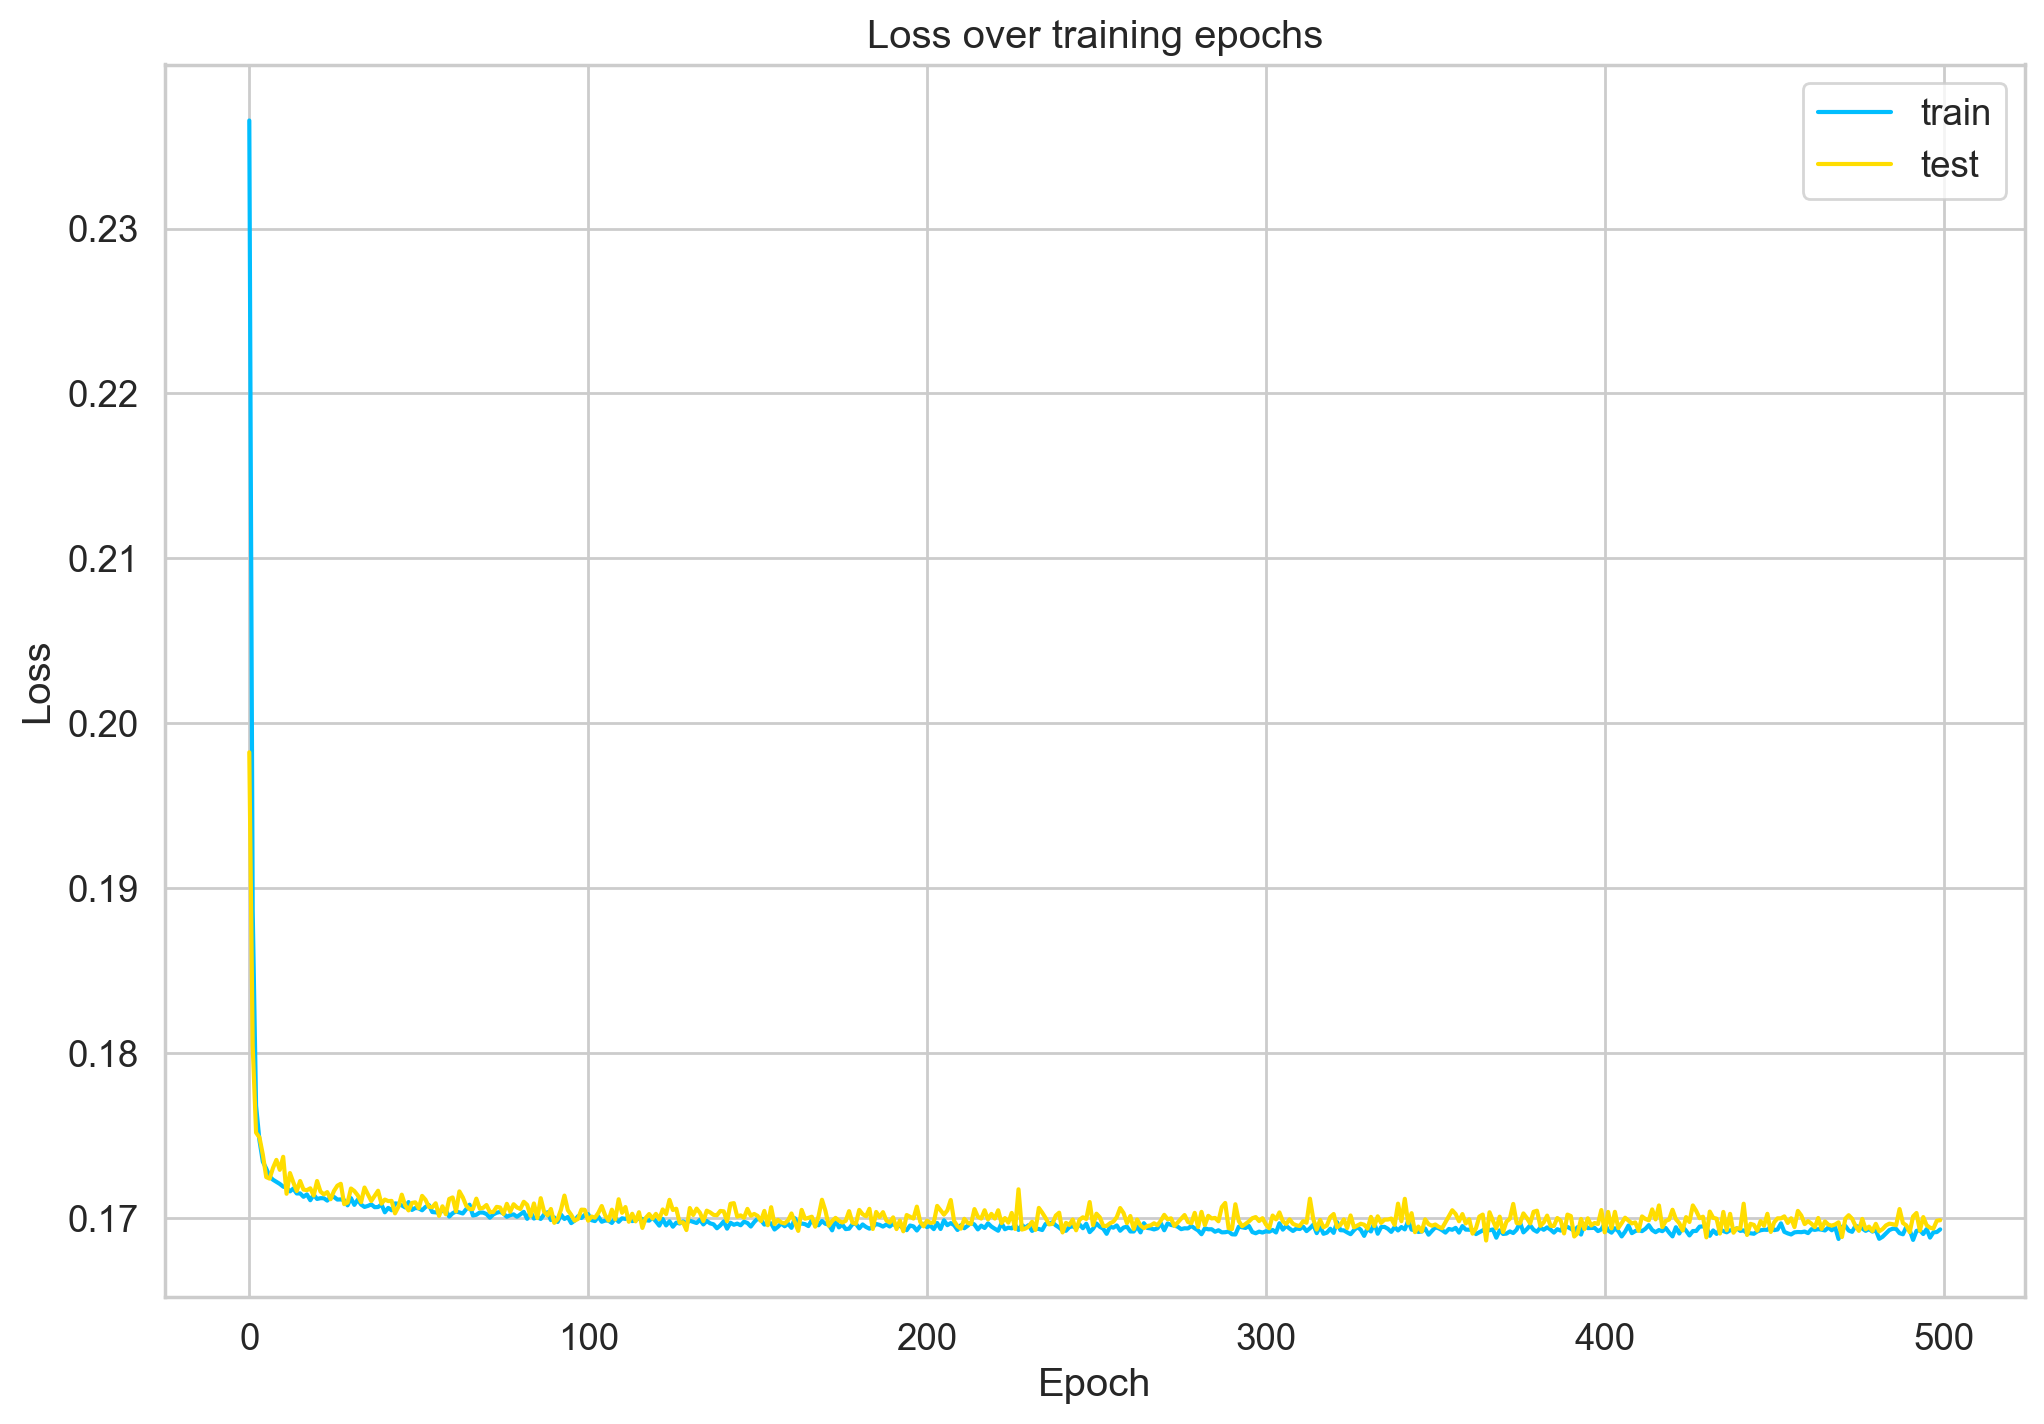

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();